In [3]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, callbacks, utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# ---------------------------
# Configuratie & seed
# ---------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

SR = 44100
DURATION = 5.0
N_MELS = 128
N_FFT = 4096
HOP_LENGTH = 512

BATCH_SIZE = 32
EPOCHS = 50
LR = 0.002
VALIDATION_SPLIT = 0.1

META_CSV = "meta/esc50.csv"
AUDIO_ROOT = "audio"
MODEL_PATH = "cnn_model.h5"
OUTPUT_DIR = "results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Categorii de exclus (nu am placa video sa fac antrenament pentru toate)
excluded_categories = [
    'frog', 'chirping_birds', 'coughing', 'can_opening', 'engine', 'cat',
    'water_drops', 'footsteps', 'washing_machine', 'train', 'hen', 'wind',
    'laughing', 'vacuum_cleaner', 'church_bells', 'insects', 'pouring_water',
    'brushing_teeth', 'clock_alarm', 'airplane', 'sheep', 'toilet_flush',
    'snoring', 'clock_tick', 'fireworks', 'crow', 'thunderstorm',
    'drinking_sipping', 'glass_breaking', 'hand_saw'
]

2025-11-19 11:07:54.290291: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 11:07:54.508459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763543274.587905   10471 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763543274.610187   10471 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763543274.768296   10471 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
# ---------------------------
# Preprocesare audio
# ---------------------------
def preprocess_audio(file_path):
    y, _ = librosa.load(file_path, sr=SR, mono=True)
    max_len = int(SR * DURATION)
    if len(y) < max_len:
        y = np.pad(y, (0, max_len - len(y)))
    else:
        y = y[:max_len]
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))
    S = librosa.feature.melspectrogram(y=y, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, power=2.0)
    S_db = librosa.power_to_db(S, ref=np.max)
    S_db = np.nan_to_num(S_db)
    # shape: (n_mels, t), extindem un canal
    S_db = np.expand_dims(S_db, axis=-1).astype(np.float32)
    return S_db

In [5]:
# ---------------------------
# Incarcare si procesare date reale
# ---------------------------
df = pd.read_csv(META_CSV)
df = df[~df['category'].isin(excluded_categories)].copy()
categories = sorted(df['category'].unique().tolist())
cat2idx = {c: i for i, c in enumerate(categories)}
idx2cat = {i: c for c, i in cat2idx.items()}
df['label'] = df['category'].map(cat2idx)

print("Categorii utilizate:", categories)

# ---------------------------
# Build dataset pentru un folder
# ---------------------------
def build_dataset(folder):
    X = []
    y = []
    filenames = []
    for _, row in df.iterrows():
        fn = row['filename']
        path = os.path.join(folder, fn)
        if not os.path.exists(path):
            # fallback la root
            path = os.path.join(AUDIO_ROOT, fn)
            
        if os.path.exists(path):
            spec = preprocess_audio(path)
            X.append(spec)
            y.append(row['label'])
            filenames.append(fn)
            
    if len(X) == 0:
        return np.empty((0, N_MELS, 1)), np.array([]), []
        
    X = np.stack(X, axis=0)
    y = np.array(y, dtype=np.int32)
    return X, y, filenames

# Datele clean pentru antrenare
X_clean, y_clean, filenames_clean = build_dataset("audio_clean")
print("Shape X_clean:", X_clean.shape, "Nr etichete:", len(y_clean))

Categorii utilizate: ['breathing', 'car_horn', 'chainsaw', 'clapping', 'cow', 'crackling_fire', 'crickets', 'crying_baby', 'dog', 'door_wood_creaks', 'door_wood_knock', 'helicopter', 'keyboard_typing', 'mouse_click', 'pig', 'rain', 'rooster', 'sea_waves', 'siren', 'sneezing']
Shape X_clean: (800, 128, 431, 1) Nr etichete: 800


In [6]:
# ---------------------------
# CNN pentru clasificare
# ---------------------------
def build_cnn(input_shape, n_classes):
    inp = layers.Input(shape=input_shape)
    
    # bloc 1
    x = layers.Conv2D(32, (5, 5), padding='same', activation='relu')(inp) 
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # bloc 2
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # bloc 3
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # bloc 4
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # clasificare
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    
    model = models.Model(inp, out)
    return model

if os.path.exists(MODEL_PATH):
    model = models.load_model(MODEL_PATH)
    print("Model incarcat din fisier:", MODEL_PATH)
else:
    model = build_cnn(input_shape=X_clean.shape[1:], n_classes=len(categories))
    model.compile(optimizer=optimizers.Adam(LR),
                  loss=losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    X_train, X_val, y_train, y_val = train_test_split(X_clean, y_clean,
                                                      test_size=VALIDATION_SPLIT,
                                                      random_state=SEED,
                                                      stratify=y_clean)
    es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=[es, rl])
    model.save(MODEL_PATH)
    
    print("Model antrenat si salvat")

I0000 00:00:1763543322.291322   10471 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4105 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/50


I0000 00:00:1763543324.349871   11271 service.cc:152] XLA service 0x7fde3c005dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763543324.349899   11271 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-11-19 11:08:44.396381: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763543324.637950   11271 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-11-19 11:08:45.624672: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1156', 8 bytes spill stores, 8 bytes spill loads

2025-11-19 11:08:45.849717: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_

 3/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.0868 - loss: 3.3849

I0000 00:00:1763543333.090341   11271 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 476ms/step - accuracy: 0.1678 - loss: 2.8921 - val_accuracy: 0.0500 - val_loss: 10.3002 - learning_rate: 0.0020
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3332 - loss: 2.1255 - val_accuracy: 0.0875 - val_loss: 7.2008 - learning_rate: 0.0020
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4091 - loss: 1.8578 - val_accuracy: 0.0625 - val_loss: 6.3521 - learning_rate: 0.0020
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4550 - loss: 1.6744 - val_accuracy: 0.1000 - val_loss: 4.5334 - learning_rate: 0.0020
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5383 - loss: 1.4444 - val_accuracy: 0.0875 - val_loss: 6.2165 - learning_rate: 0.0020
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5374 - loss: 1.3400 - val_accuracy: 0.0625 - val_loss: 12.0435 - learning_rate: 0.0020
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6211 - loss: 1.2215 - val_accuracy: 

Model antrenat si salvat


In [7]:
# ---------------------------
# Spectral Bias Score - practic afla ce frecvente si momente sunt cele mai critice pentru ca CNN-ul sa faca clasificarea
# ---------------------------

def calculate_sbs_spectrogram(model, input_spec, label_onehot, thresholds=[1000, 2000, 4000, 8000, 16000]):
    """
    input_spec: spectrogram (1, n_mels, T, 1)
    label_onehot: (1, n_classes)
    """
    x = tf.convert_to_tensor(input_spec, dtype=tf.float32)
    y = tf.convert_to_tensor(label_onehot, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(x)
        preds = model(x, training=False)
        loss = tf.keras.losses.categorical_crossentropy(y, preds)
    grad = tape.gradient(loss, x).numpy().squeeze()  # shape (n_mels, T)
    
    if grad.ndim == 3:  # daca mai are un canal
        grad = grad[..., 0]
        
    E_mel = np.sum(np.abs(grad)**2, axis=1)  # suma pe timp => energie pe mel bin
    n_mels = E_mel.shape[0]
    
    mel_centers = librosa.mel_frequencies(n_mels=n_mels, fmin=20.0, fmax=SR/2.0)
    total_energy = np.sum(E_mel)
    sbs = {}
    
    for t in thresholds:
        mask = mel_centers <= t
        E_low = float(np.sum(E_mel[mask]))
        sbs[t] = float(E_low / total_energy) if total_energy > 0 else 0.0
    return sbs, mel_centers, E_mel


# ---------------------------
# Grad-CAM util (cand suprapunem peste spectrograma, zonele rosii sau galbene indica frecventele si momentele pe care s-a bazat cel mai mult modelul in clasficare
# ---------------------------
def make_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
        
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), pred_index.numpy()

In [8]:
# ---------------------------
# Evaluare + ploturi
# ---------------------------
def evaluate_and_analyse(folder, do_sbs=True, do_gradcam=True, n_gradcam_examples=4):
    X, y, filenames = build_dataset(folder)
    if len(X) == 0:
        print(f"Folder {folder} nu are date sau nu exista")
        return

    # Predictii
    preds_proba = model.predict(X, batch_size=BATCH_SIZE)
    preds = np.argmax(preds_proba, axis=1)

    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds, average='weighted')
    print(f"{folder}: Accuracy = {acc:.4f}, F1 = {f1:.4f}, N = {len(y)}")

    # Matrice confuzie
    cm = confusion_matrix(y, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[idx2cat[i] for i in range(len(categories))],
                yticklabels=[idx2cat[i] for i in range(len(categories))])
    
    plt.title(f"Matrice confuzie: {folder}")
    
    plt.xlabel("Predictie")
    plt.ylabel("Adevar")
    plt.show()

    # Raport/metrici clasificare
    report = classification_report(y, preds, output_dict=True, target_names=[idx2cat[i] for i in range(len(categories))])
    report_df = pd.DataFrame(report).iloc[:-1, :].T
    metrics_df = report_df[['precision', 'recall', 'f1-score']].fillna(0)
    plt.figure(figsize=(12, max(6, 0.3*len(metrics_df))))
    sns.heatmap(metrics_df, annot=True, fmt=".3f", cmap="RdYlGn")
    
    plt.title(f"Metrici pe clase: {folder}")
    plt.show()

    # Spectral Bias Score
    if do_sbs:
        all_sbs = {t: [] for t in [1000, 2000, 4000, 8000, 16000]}
        all_E = []
        mel_centers = None
        
        for i in range(len(X)):
            onehot = utils.to_categorical([y[i]], num_classes=len(categories))
            sbs_dict, centers, E_mel = calculate_sbs_spectrogram(model, np.expand_dims(X[i], 0), onehot)
            for t in sbs_dict:
                all_sbs[t].append(sbs_dict[t])
            all_E.append(E_mel)
            if mel_centers is None:
                mel_centers = centers

        # plot SBS mediu
        avg_sbs = {t: np.mean(all_sbs[t]) for t in all_sbs}
        print("SBS mediu:", avg_sbs)
        plt.figure()
        plt.bar([str(t) for t in avg_sbs.keys()], [avg_sbs[t] for t in avg_sbs.keys()])
        
        plt.xlabel("Threshold frecventa (Hz)")
        plt.ylabel("SBS mediu")
        
        plt.title(f"SBS mediu: {folder}")
        plt.show()

        # plot energie medie pe mel-centers
        mean_E = np.mean(np.stack(all_E, axis=0), axis=0)
        
        plt.figure(figsize=(8, 4))
        plt.plot(mel_centers, mean_E)

        # sa le vedem logaritmic nu liniar
        plt.xscale('log')
        log_ticks = [256, 512, 1024, 2048, 4096, 8192, 16384]
        plt.xticks(log_ticks, [f'{t} Hz' for t in log_ticks])
        
        plt.xlabel("Frecventa (Hz aprox)")
        plt.ylabel("Energie medie (pe mel-bin)")
        
        plt.title(f"Energie spectrala medie: {folder}")
        plt.grid(True, which='both')
        plt.show()

    # Grad-CAM pe cateva exemple (ca sunt prea multe)
    if do_gradcam:
        # gaseste un layer conv final
        last_conv = None
        
        for layer in reversed(model.layers):
            if isinstance(layer, layers.Conv2D):
                last_conv = layer.name
                break
        if last_conv is None:
            print("Nu am gasit layer Conv2D pentru Grad-CAM")
        else:
            # print("Folosind layer pentru Grad-CAM:", last_conv)
            idxs = list(range(min(n_gradcam_examples, len(X))))
            plt.figure(figsize=(12, 3 * len(idxs)))
            
            for j, i in enumerate(idxs):
                spec = X[i:i+1]
                heatmap, pred_class = make_gradcam_heatmap(model, spec, last_conv)
                pred_cat = idx2cat[pred_class]
                true_cat = idx2cat[y[i]]

                # spec plot
                ax1 = plt.subplot(len(idxs), 2, j*2 + 1)
                spec_img = spec[0, :, :, 0]
                librosa.display.specshow(spec_img, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', ax=ax1)
                ax1.set_title(f"Spec (true: {true_cat}, pred: {pred_cat})")

                # heatmap plot
                ax2 = plt.subplot(len(idxs), 2, j*2 + 2)
                ax2.imshow(heatmap, cmap='jet', alpha=0.5)
                ax2.set_title("Grad-CAM heatmap")
                plt.colorbar(ax2.images[0], ax=ax2)

            plt.tight_layout()
            plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
audio_clean: Accuracy = 0.9762, F1 = 0.9762, N = 800


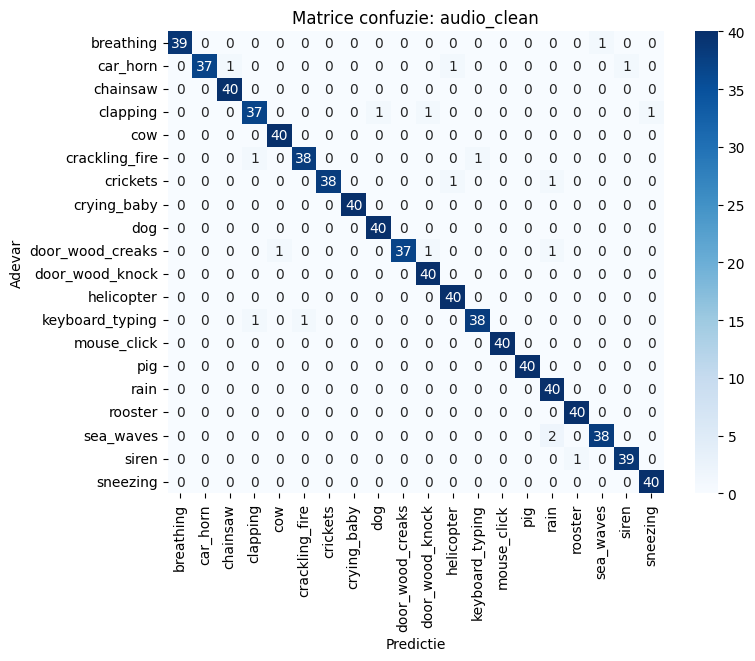

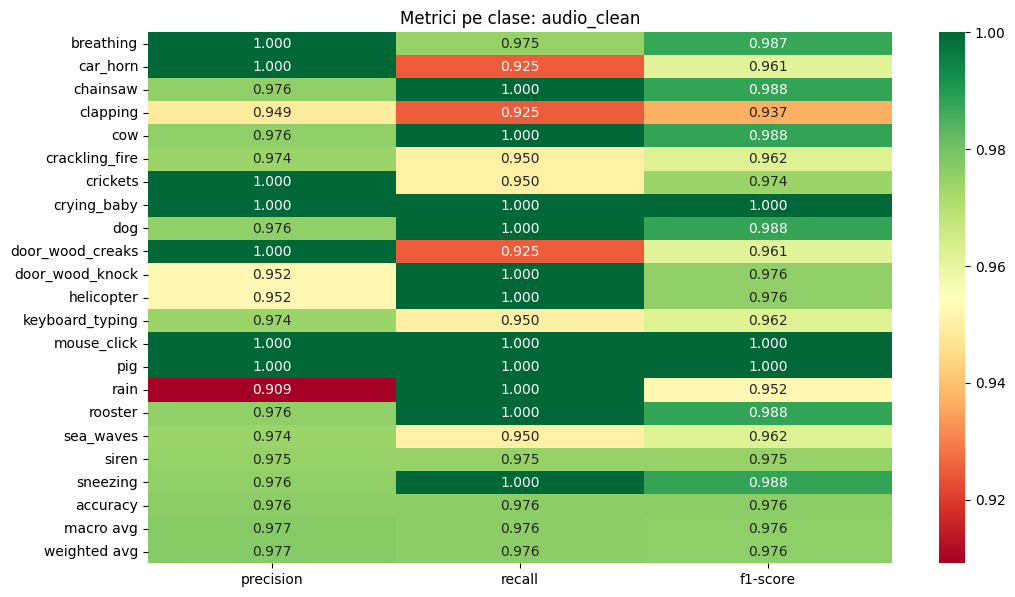

SBS mediu: {1000: 0.3862755782838526, 2000: 0.5817087535117625, 4000: 0.7530883617984577, 8000: 0.8776148524204868, 16000: 0.9830619057554596}


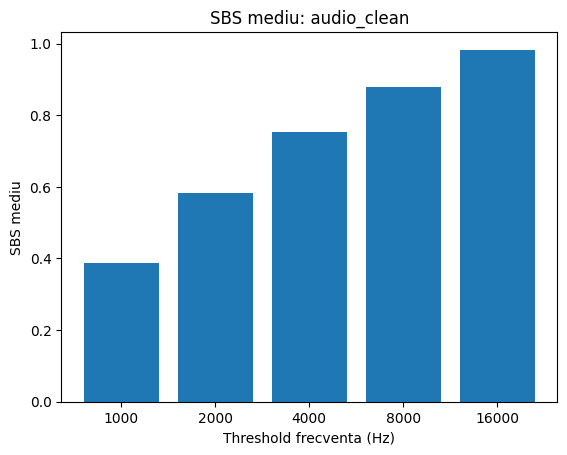

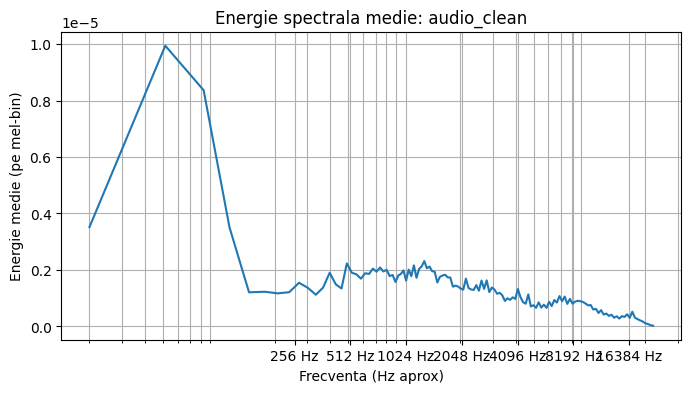

/home/marianpc/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 128, 431, 1))
  warnings.warn(msg)


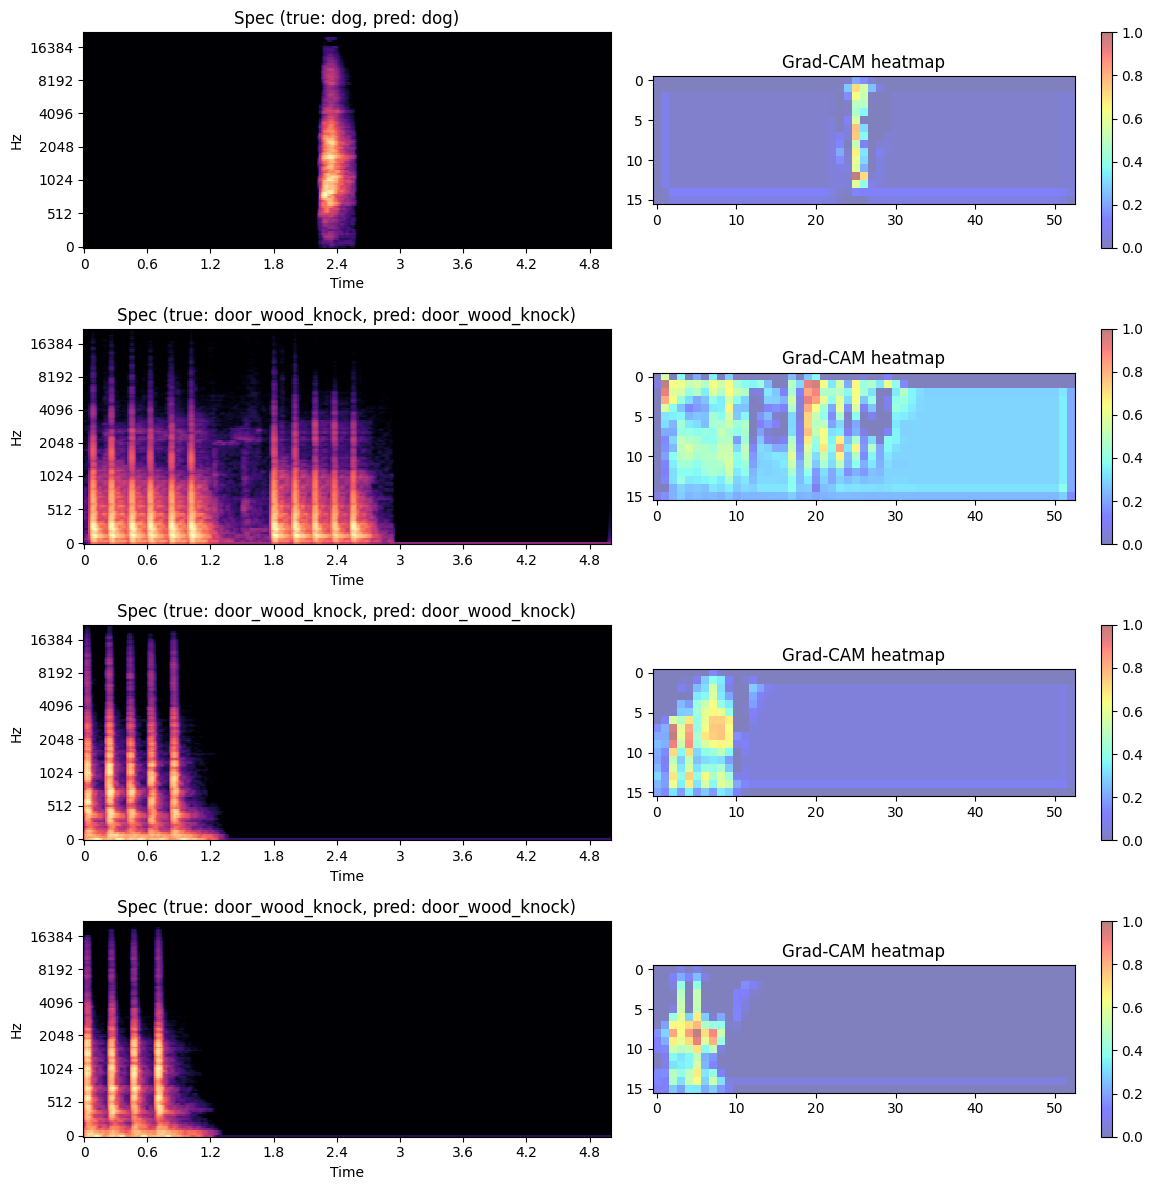

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
audio_white_noise: Accuracy = 0.1212, F1 = 0.0634, N = 800


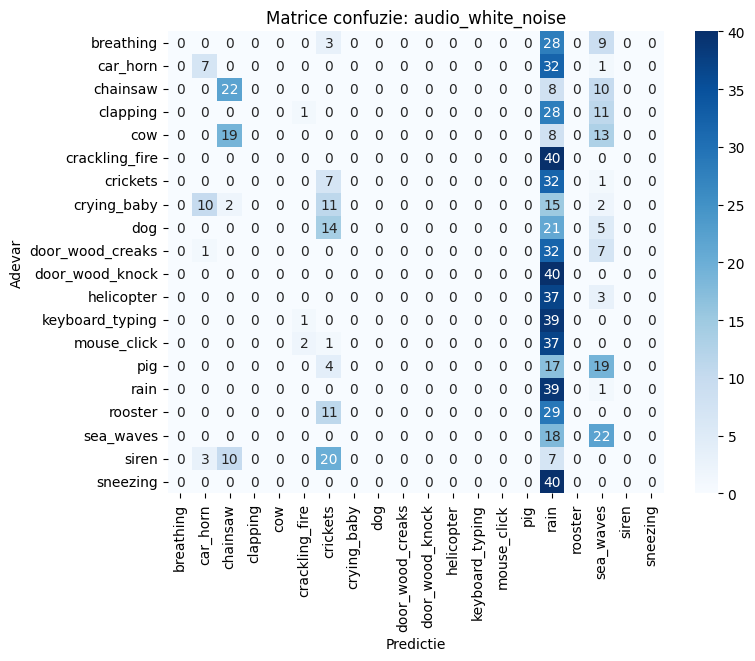

/home/marianpc/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marianpc/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marianpc/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


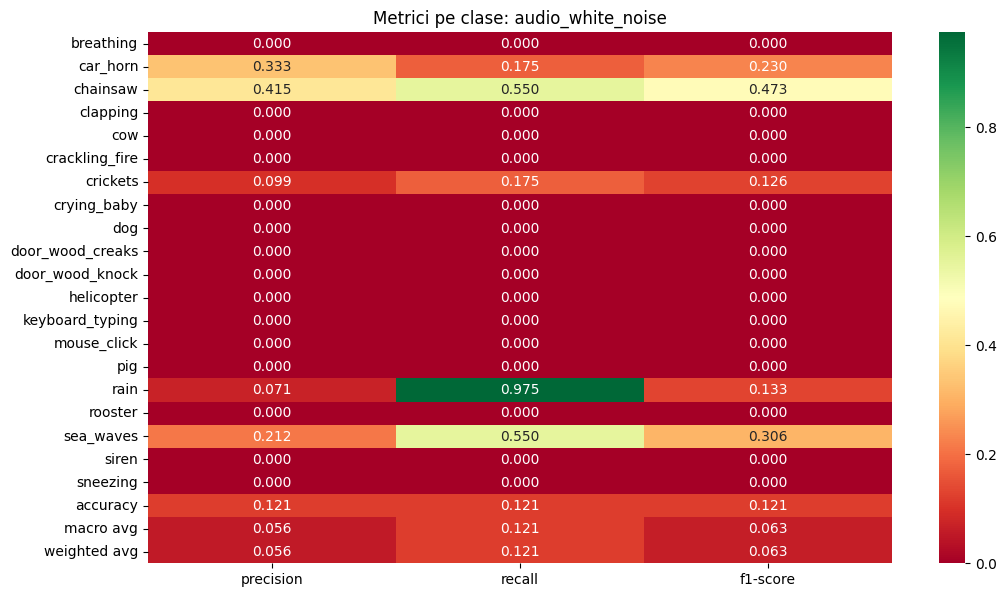

SBS mediu: {1000: 0.38790890363901925, 2000: 0.586775494655501, 4000: 0.7399964391630047, 8000: 0.8461795272809567, 16000: 0.9637207685105038}


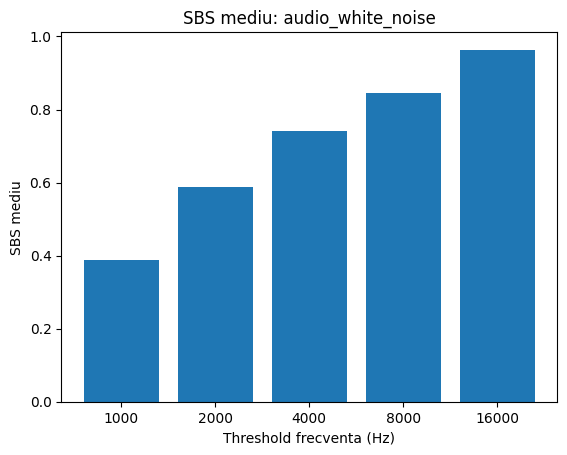

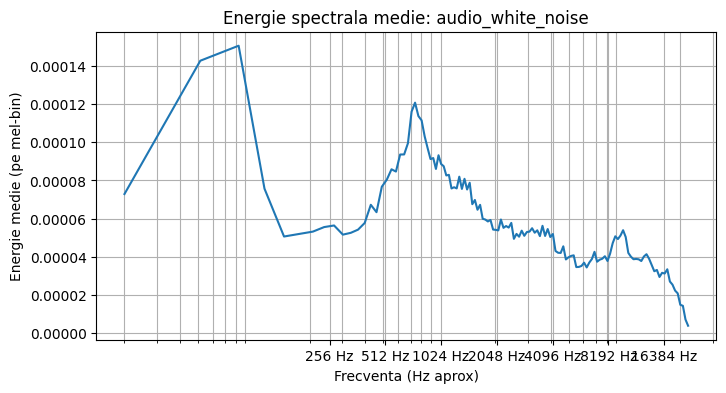

/home/marianpc/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 128, 431, 1))
  warnings.warn(msg)


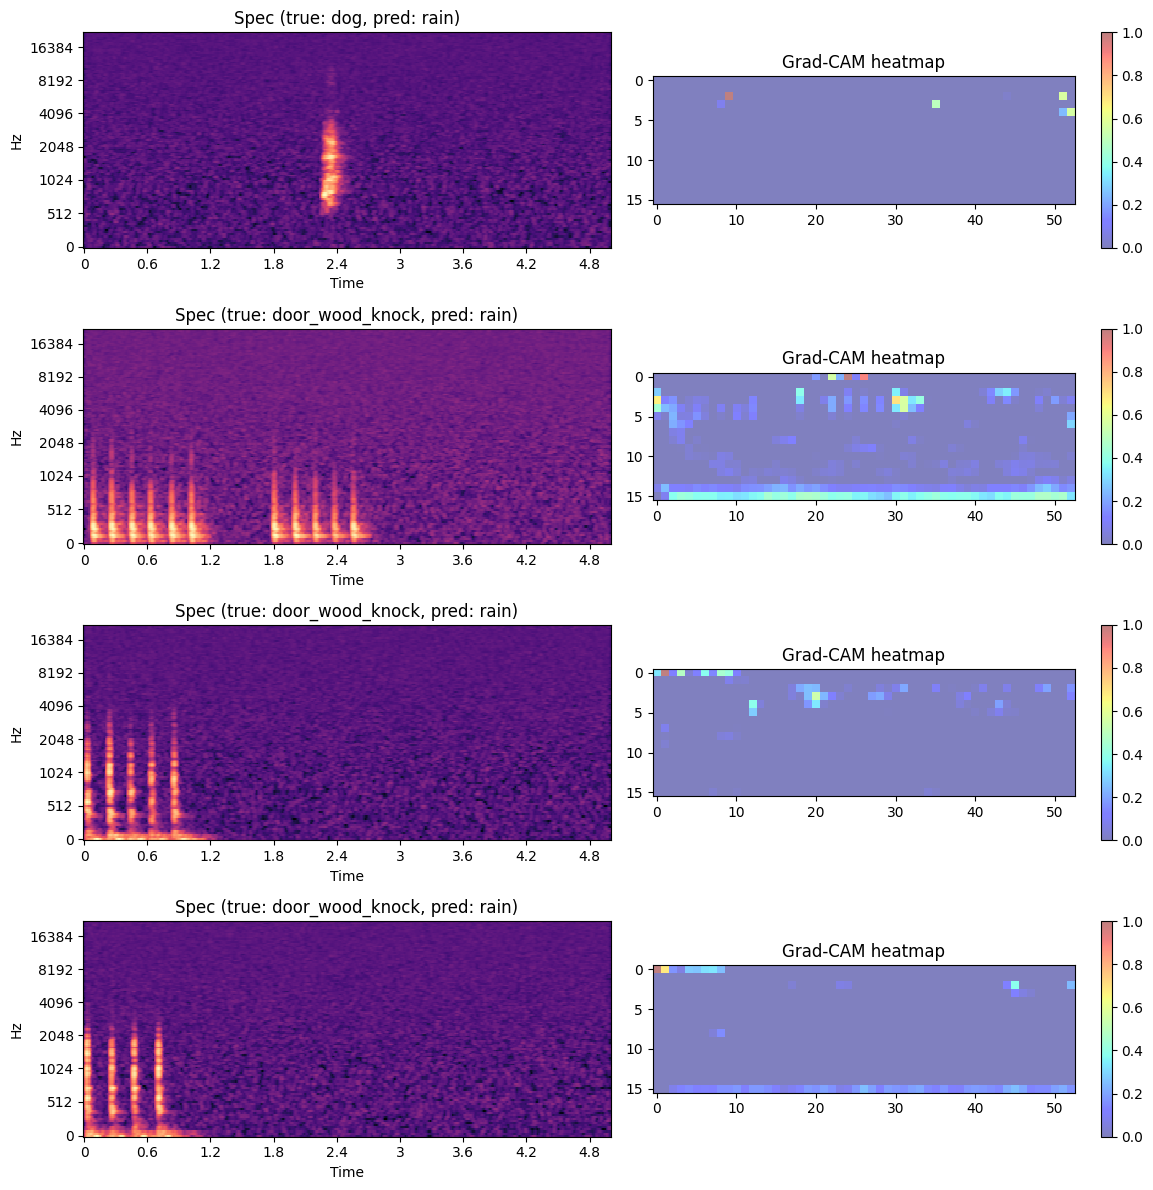

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
audio_low_pass: Accuracy = 0.9300, F1 = 0.9306, N = 800


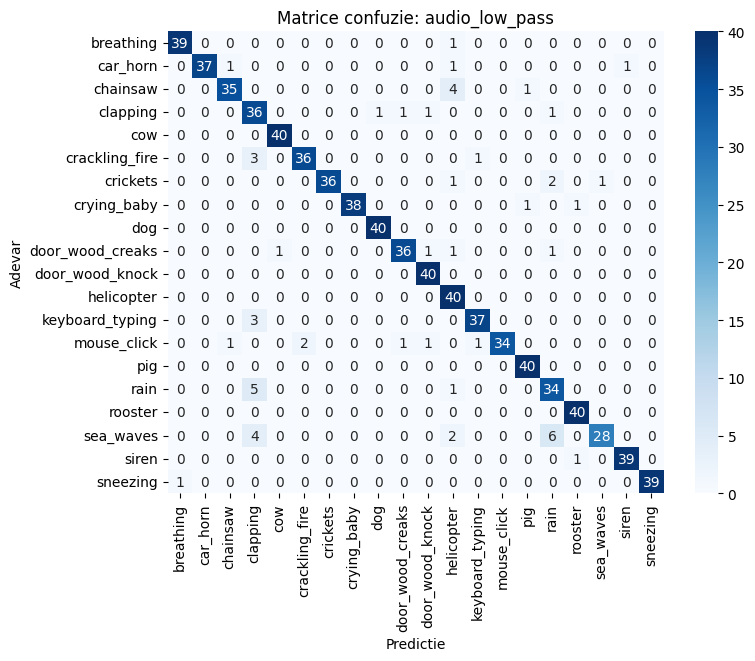

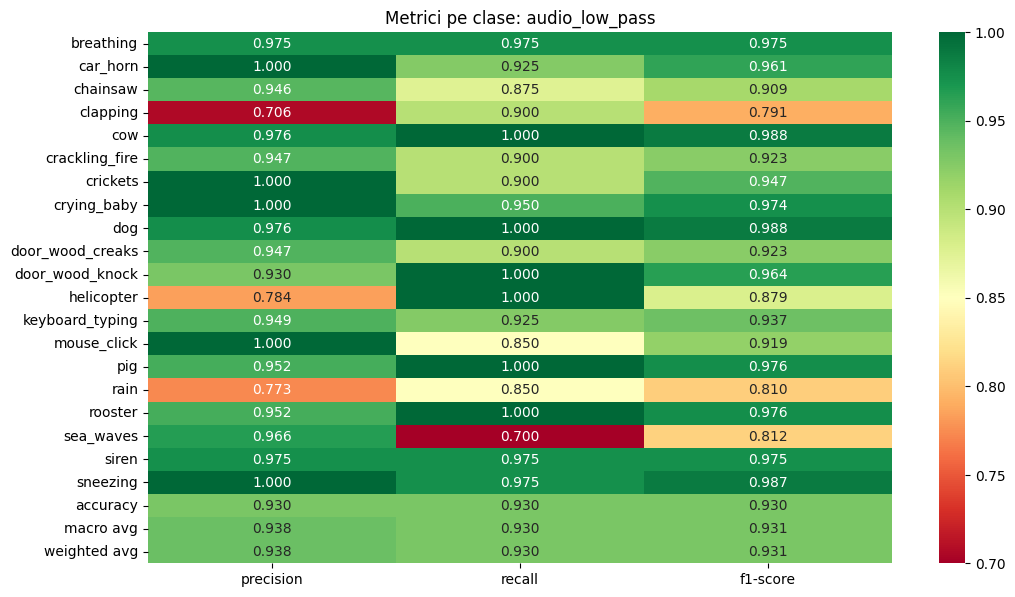

SBS mediu: {1000: 0.37965447588856577, 2000: 0.5862339605336853, 4000: 0.7698655983975797, 8000: 0.9228224778985711, 16000: 0.9935334310095727}


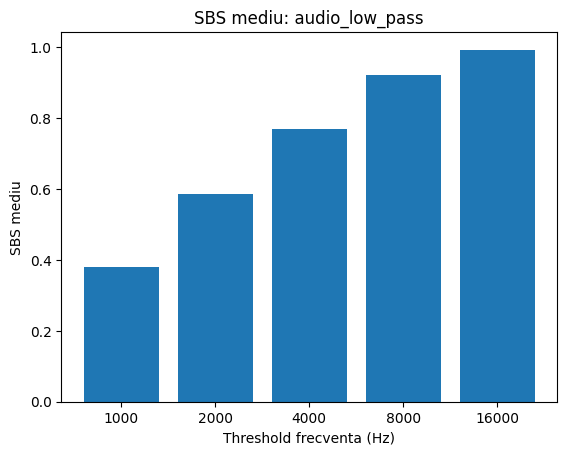

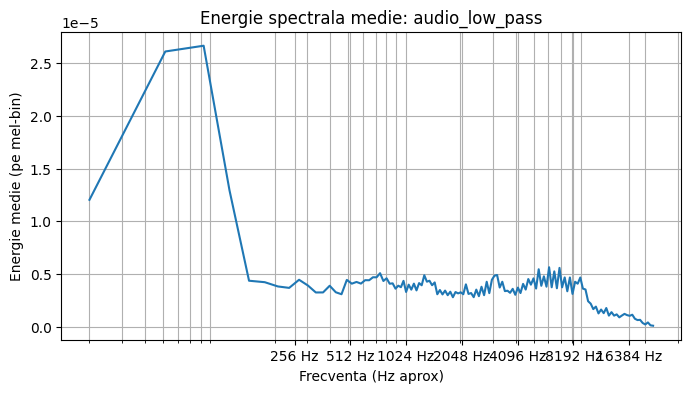

/home/marianpc/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 128, 431, 1))
  warnings.warn(msg)


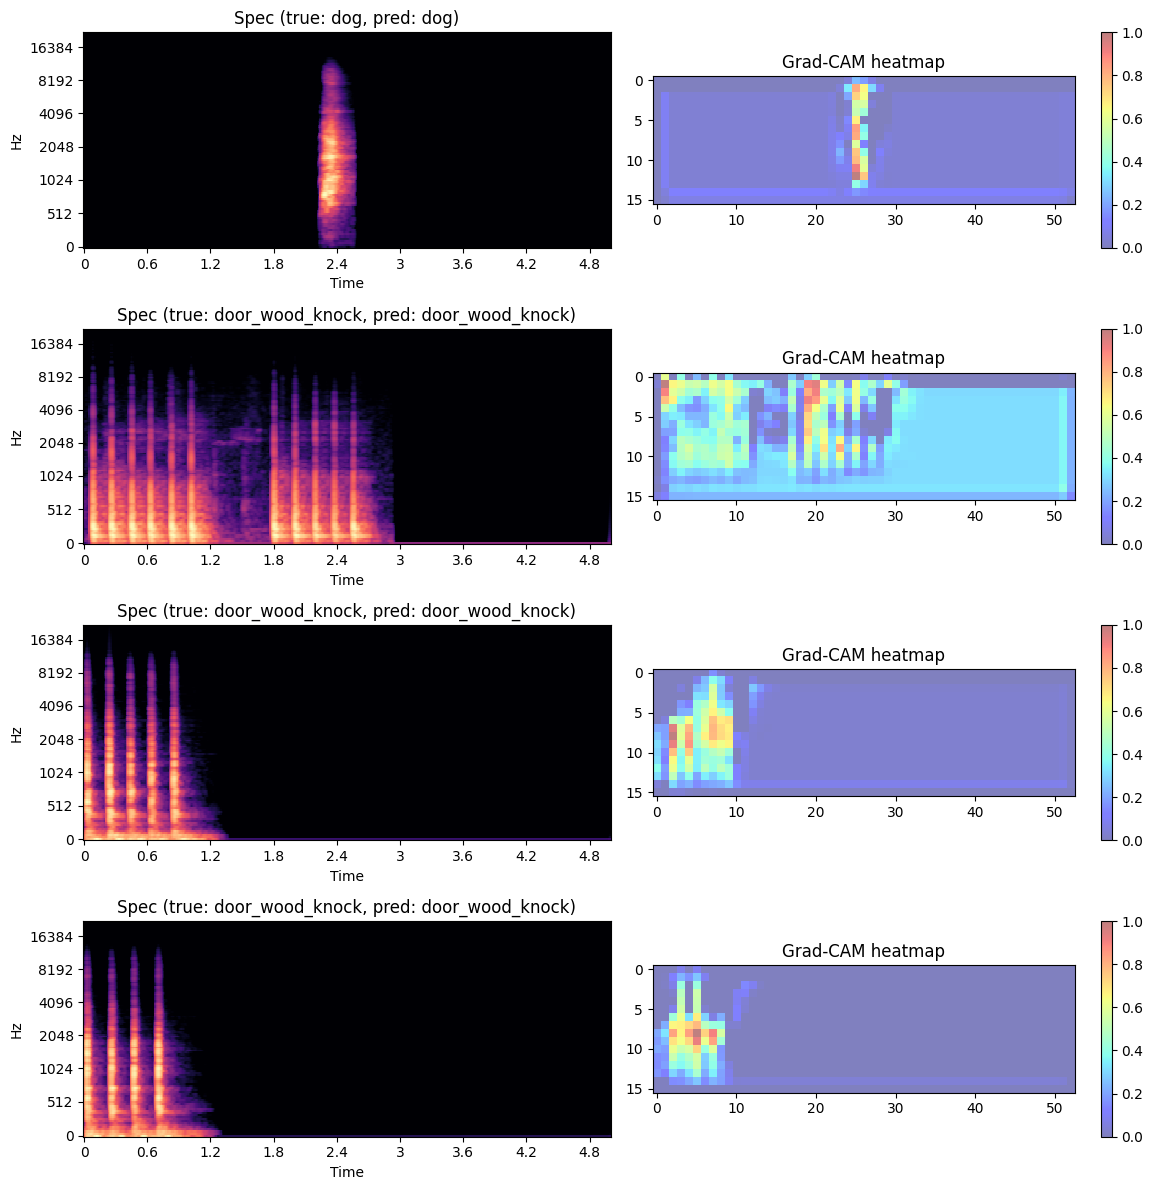

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
audio_high_pass: Accuracy = 0.4888, F1 = 0.4831, N = 800


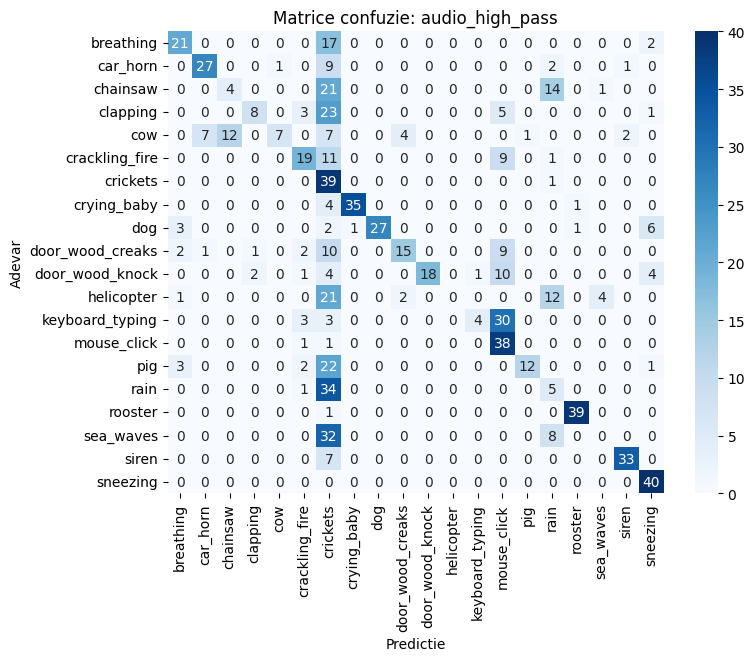

/home/marianpc/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marianpc/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marianpc/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


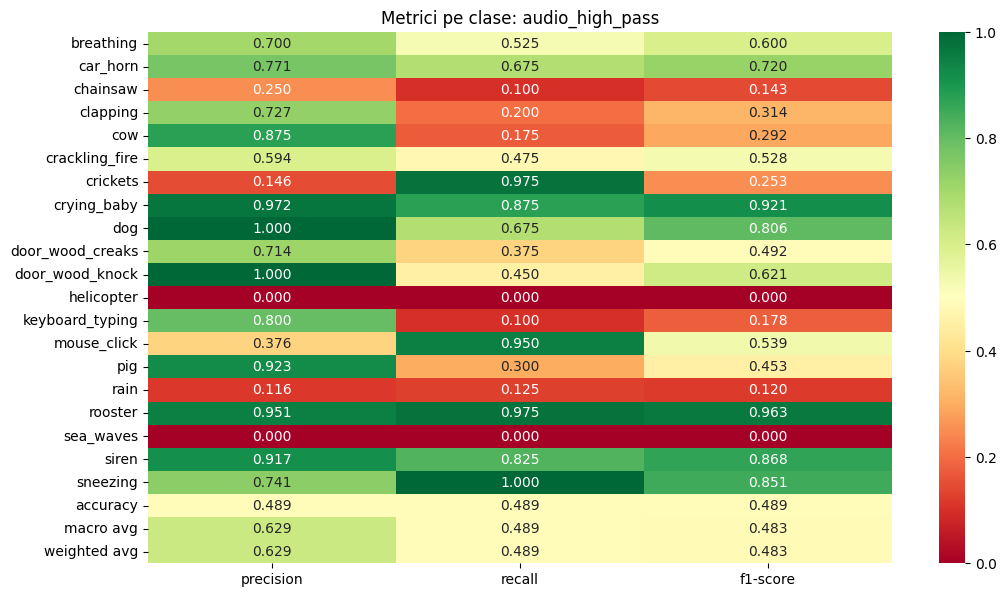

SBS mediu: {1000: 0.15736341030322032, 2000: 0.42750138288841155, 4000: 0.669533776567564, 8000: 0.8211455735049937, 16000: 0.9590415182000567}


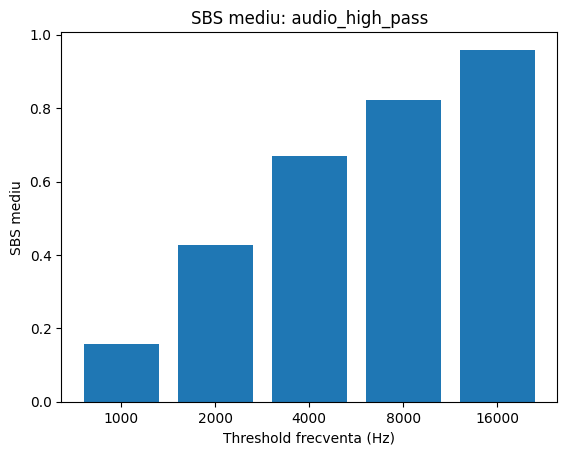

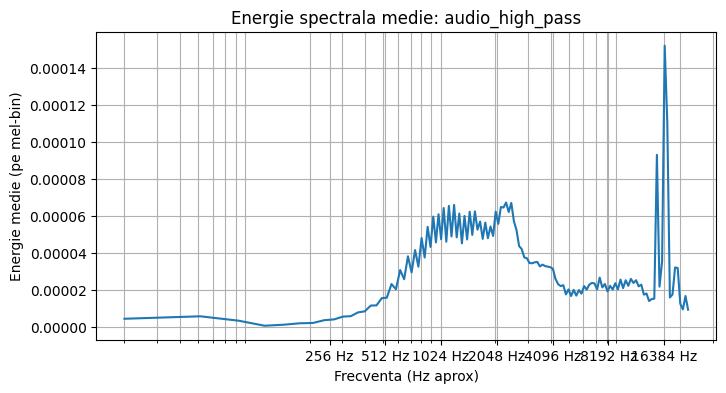

/home/marianpc/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 128, 431, 1))
  warnings.warn(msg)


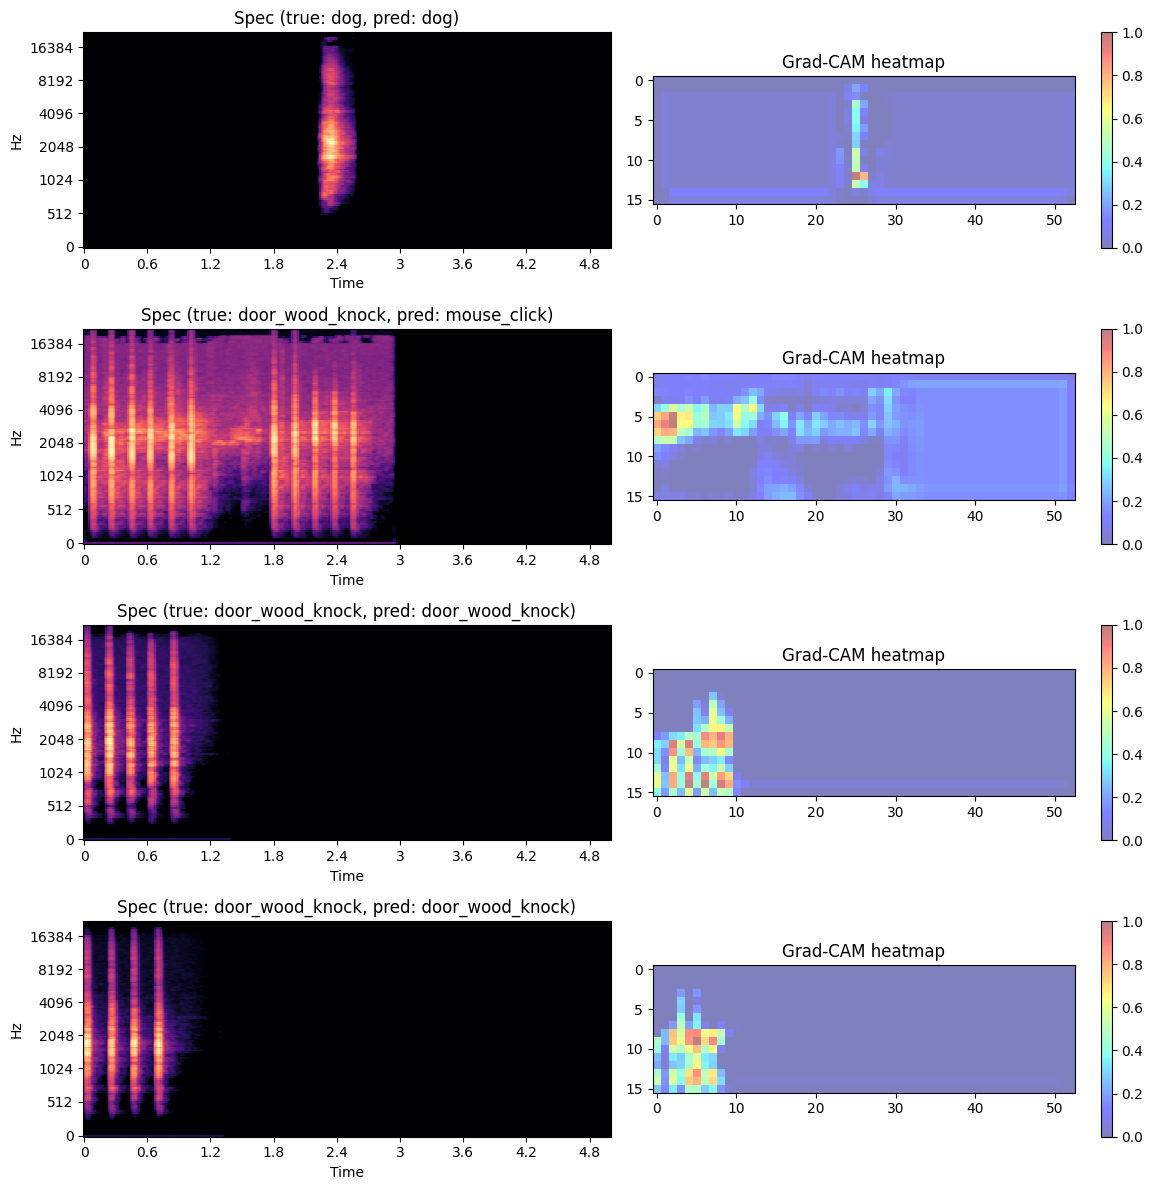

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
audio_low_high_pass: Accuracy = 0.7725, F1 = 0.7663, N = 800


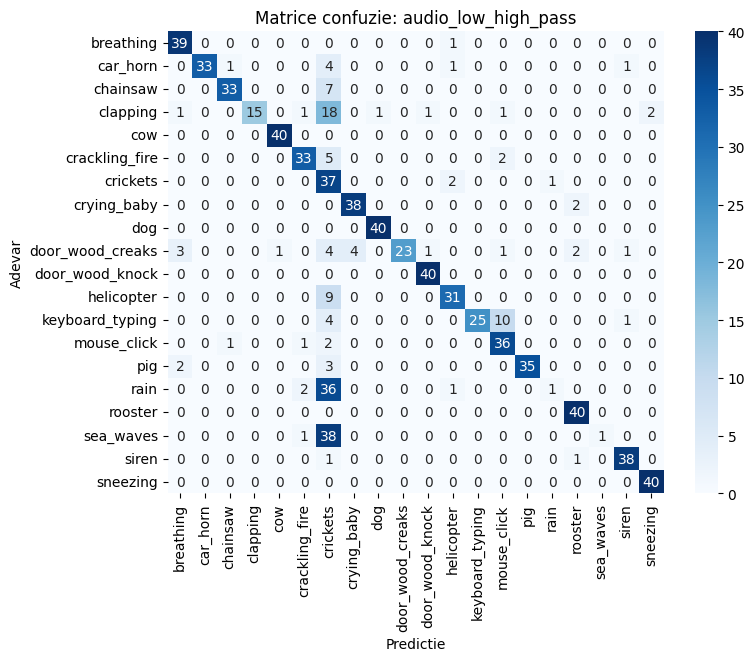

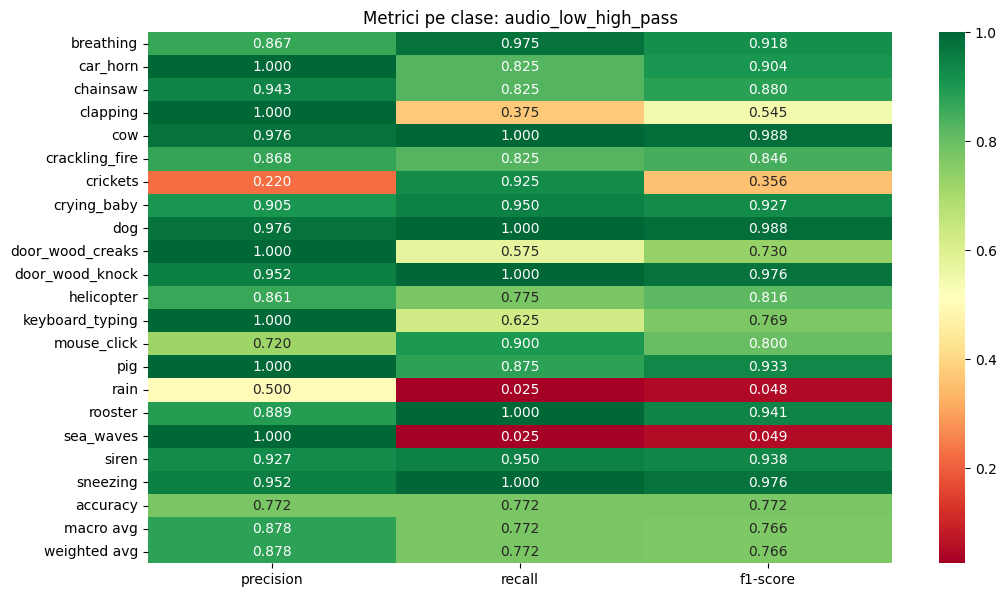

SBS mediu: {1000: 0.37195921792644204, 2000: 0.5811703653841165, 4000: 0.7599412012134046, 8000: 0.901222540748654, 16000: 0.9850124668796794}


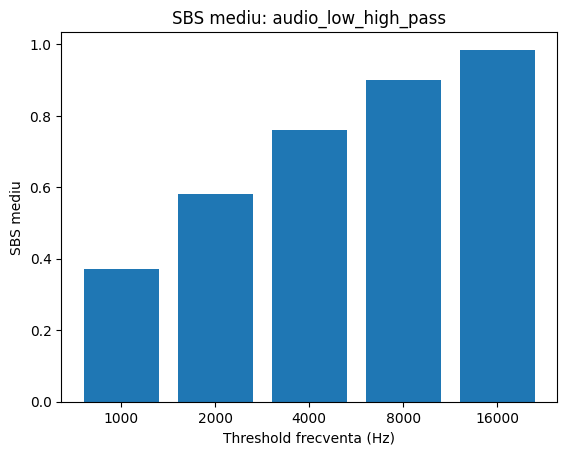

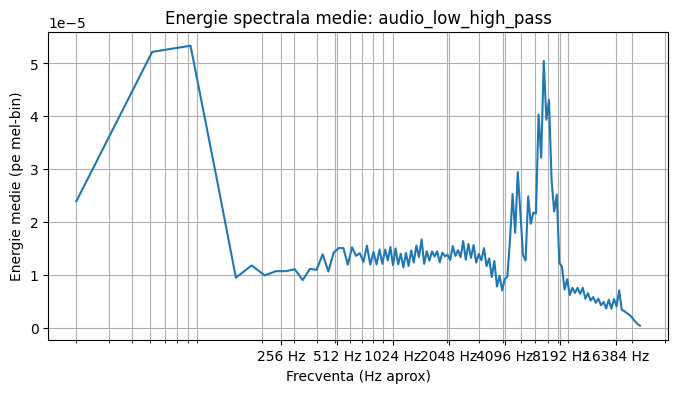

/home/marianpc/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 128, 431, 1))
  warnings.warn(msg)


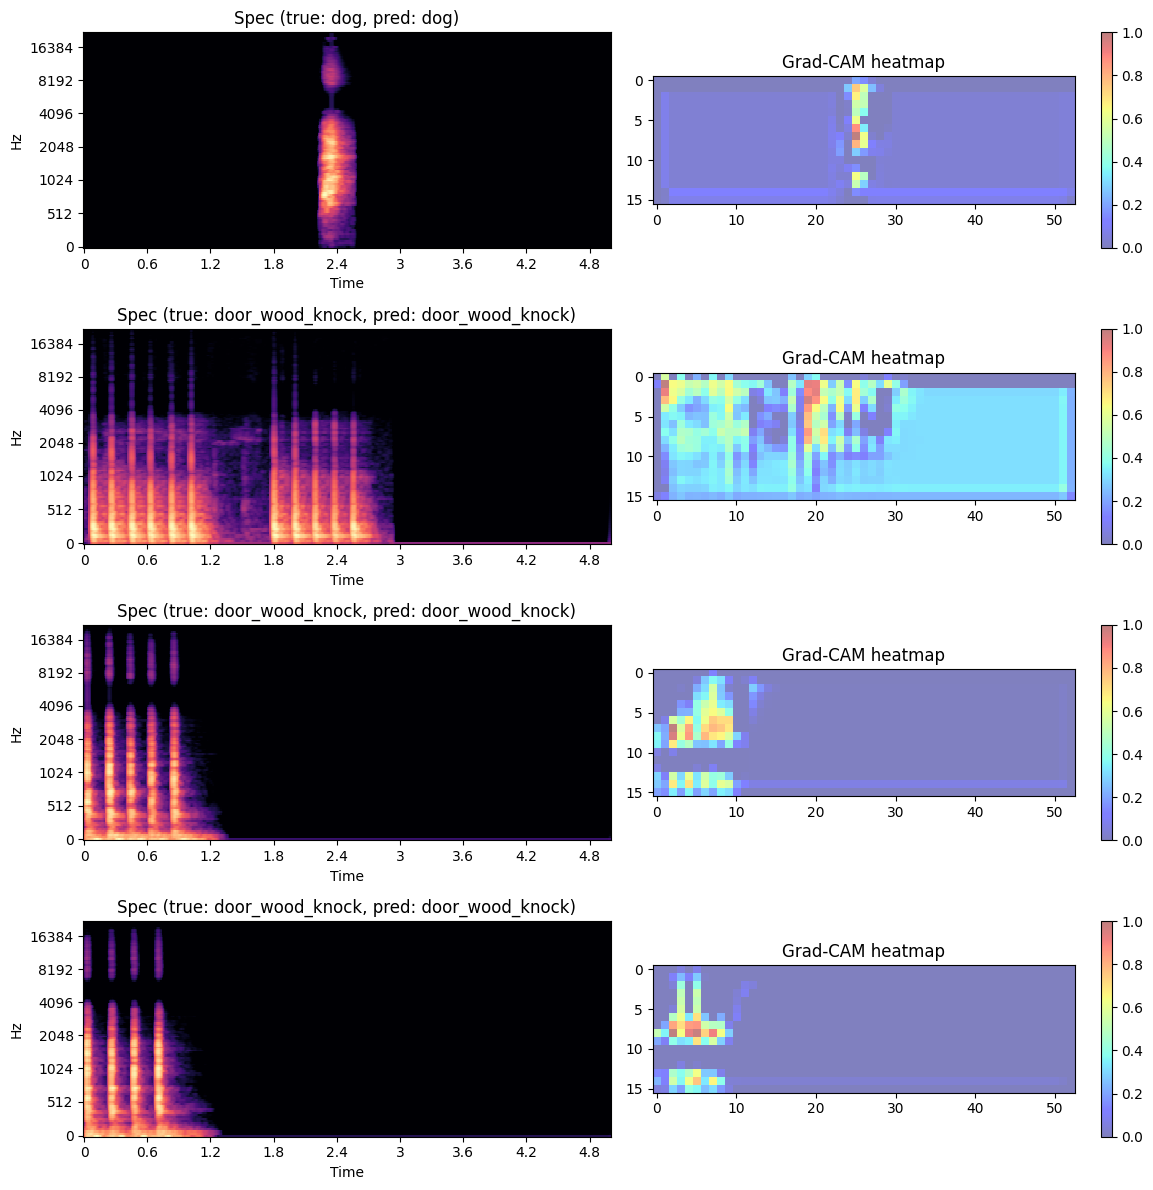

Gata


In [9]:
# ---------------------------
# Analiza pe fiecare set de audio-uri
# ---------------------------

folders = ['audio_clean', 'audio_white_noise', 'audio_low_pass', 'audio_high_pass', 'audio_low_high_pass']
for f in folders:
    evaluate_and_analyse(f, do_sbs=True, do_gradcam=True)

print("Gata")